In [473]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import joblib
from sklearn.utils import shuffle
import re

Loading in the Data:

In [215]:
df = pd.read_csv('Ninja Vegas Results.csv') #For April 2018

# Data Cleaning

There are columns without non-null values, let's see if we can clean the set.

In [216]:
df.head(3)

,SegID,DBName,Brand,Location,Network,Sport,League,Away,Home,Venue,...,Size Weight.1,PictureFrameVis%.1,Duration Weight.1,SOV/Clutter Weight,Clutter/SOV,Size Score,Location Score,Duration Score,ME Score,ME Value
0,1,NINJAVEGAS18,Purple,Logo Bug,NaN,Esports,StreamHatchet,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0.0,0.2,0.4,5.18%,$ 259.31
1,2,NINJAVEGAS18,Purple,Logo Bug,NaN,Esports,StreamHatchet,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0.0,0.2,0.4,5.18%,$ 259.31
2,3,NINJAVEGAS18,Purple,Logo Bug,NaN,Esports,StreamHatchet,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0.0,0.2,0.4,5.18%,$ 259.31


In [217]:
columns_with_all_null_values = df.columns[df.isnull().sum()==df.shape[0]].tolist()

In [218]:
columns_with_all_null_values

['Network',
 'Away',
 'Home',
 'Venue',
 'Bbox_x1',
 'Bbox_y1',
 'Bbox_x2',
 'Bbox_y2',
 'Video_Height',
 'Video_Width',
 'SC-X2',
 'SC-Y2',
 'Center',
 'Calc',
 'BullseyePercent',
 'PF_X_UL',
 'PF_Y_UL',
 'PF_X_LL',
 'PF_Y_LL',
 'PF_X_UR',
 'PF_Y_UR',
 'PF_X_LR',
 'PF_Y_LR',
 'PictureFrameVis%',
 'Size Weight.1',
 'PictureFrameVis%.1',
 'Duration Weight.1',
 'SOV/Clutter Weight']

We will proceed to remove them.

In [219]:
df=df.drop(columns_with_all_null_values, axis=1)

In [220]:
df.head(3)

,SegID,DBName,Brand,Location,Sport,League,Broadcast Day,Broadcast Date,Start Time,End Time,...,Location %,Clear/Unclear,Brand Size %,Size Weight,Clutter/SOV,Size Score,Location Score,Duration Score,ME Score,ME Value
0,1,NINJAVEGAS18,Purple,Logo Bug,Esports,StreamHatchet,Saturday,04-21-2018,03:19:07,03:19:13,...,20.00%,1,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31
1,2,NINJAVEGAS18,Purple,Logo Bug,Esports,StreamHatchet,Saturday,04-21-2018,03:19:21,03:19:27,...,20.00%,1,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31
2,3,NINJAVEGAS18,Purple,Logo Bug,Esports,StreamHatchet,Saturday,04-21-2018,03:19:35,03:19:41,...,20.00%,1,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31


In [221]:
df.isnull().any() #There are no NAN values left in our data set!

SegID                    False
DBName                   False
Brand                    False
Location                 False
Sport                    False
League                   False
Broadcast Day            False
Broadcast Date           False
Start Time               False
End Time                 False
Duration Time            False
Duration Weight          False
30 Second Equivalents    False
Location %               False
Clear/Unclear            False
Brand Size %             False
Size Weight              False
Clutter/SOV              False
Size Score               False
Location Score           False
Duration Score           False
ME Score                 False
 ME Value                False
dtype: bool

Some time values start with 0 and others do not, so I will add a 0 to those which do not

In [222]:
df.loc[[0,1,2,df.shape[0]-1], 'Start Time':'End Time']

,Start Time,End Time
0,03:19:07,03:19:13
1,03:19:21,03:19:27
2,03:19:35,03:19:41
1481,1:35:38,1:36:09


In [223]:
df.loc[:,'Start Time':'End Time']=df.loc[:,'Start Time':'End Time'].applymap(lambda x: '0'+x if (len(x.split(':')[0])<2) else x)

In [224]:
df.loc[[0,1,2,df.shape[0]-1], 'Start Time':'End Time']
#As you can tell, that is now fixed

,Start Time,End Time
0,03:19:07,03:19:13
1,03:19:21,03:19:27
2,03:19:35,03:19:41
1481,01:35:38,01:36:09


Perhaps the time at which the commercial time begins is a factor in determining the EMV value. Therefore we will make a column with the starting hours, which we will one-hot-encode later on!

In [225]:
df['Start Time Hour']=df[['Start Time']].applymap(lambda x: x.split(':')[0])

I doubt that the start and end time are of much help, so we will drop them.

In [226]:
df.drop(['Start Time', 'End Time'], axis=1, inplace=True)

In [227]:
df.head(3)

,SegID,DBName,Brand,Location,Sport,League,Broadcast Day,Broadcast Date,Duration Time,Duration Weight,...,Clear/Unclear,Brand Size %,Size Weight,Clutter/SOV,Size Score,Location Score,Duration Score,ME Score,ME Value,Start Time Hour
0,1,NINJAVEGAS18,Purple,Logo Bug,Esports,StreamHatchet,Saturday,04-21-2018,6.0,40.00%,...,1,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31,03
1,2,NINJAVEGAS18,Purple,Logo Bug,Esports,StreamHatchet,Saturday,04-21-2018,6.0,40.00%,...,1,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31,03
2,3,NINJAVEGAS18,Purple,Logo Bug,Esports,StreamHatchet,Saturday,04-21-2018,6.0,40.00%,...,1,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31,03


Before we can begin analyzing what factors are responsible for determining the output, we must get rid of data that does not contribute to our output. We can delete columns with only one unique value without having repercussions in quality of our analysis.

In [228]:
df.nunique()

SegID                    1157
DBName                      4
Brand                       2
Location                    5
Sport                       1
League                      1
Broadcast Day               1
Broadcast Date              1
Duration Time              68
Duration Weight            17
30 Second Equivalents      54
Location %                 11
Clear/Unclear               1
Brand Size %               86
Size Weight                86
Clutter/SOV                 2
Size Score                 12
Location Score             11
Duration Score             17
ME Score                  233
 ME Value                 365
Start Time Hour             5
dtype: int64

In [229]:
columns_to_drop = df.columns[df.nunique()==1].tolist()

In [230]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [231]:
df.head(5)

,SegID,DBName,Brand,Location,Duration Time,Duration Weight,30 Second Equivalents,Location %,Brand Size %,Size Weight,Clutter/SOV,Size Score,Location Score,Duration Score,ME Score,ME Value,Start Time Hour
0,1,NINJAVEGAS18,Purple,Logo Bug,6.0,40.00%,20%,20.00%,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31,03
1,2,NINJAVEGAS18,Purple,Logo Bug,6.0,40.00%,20%,20.00%,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31,03
2,3,NINJAVEGAS18,Purple,Logo Bug,6.0,40.00%,20%,20.00%,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31,03
3,4,NINJAVEGAS18,Purple,Logo Bug,6.0,40.00%,20%,20.00%,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31,03
4,5,NINJAVEGAS18,Purple,Logo Bug,6.0,40.00%,20%,20.00%,0.11%,0.22%,1,0.0,0.2,0.4,5.18%,$ 259.31,03


Lastly, we need to alter the numerical string columns to numerical columns by first removing the percentage and dollar sign symbols!

In [232]:
str_to_number_cols = ['Duration Weight', '30 Second Equivalents', 'Location %', 'Brand Size %', 
    'Size Weight', 'ME Score', ' ME Value ', 'Start Time Hour']

In [233]:

df[str_to_number_cols]=df[str_to_number_cols].applymap(lambda x: float(re.sub('[\,$%]','',x)))

In [234]:
#Great! Now that we got rid of the string symbols and converted our values to numerical, we have a data set that we can work with!
df.head(4)

,SegID,DBName,Brand,Location,Duration Time,Duration Weight,30 Second Equivalents,Location %,Brand Size %,Size Weight,Clutter/SOV,Size Score,Location Score,Duration Score,ME Score,ME Value,Start Time Hour
0,1,NINJAVEGAS18,Purple,Logo Bug,6.0,40.0,20.0,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0
1,2,NINJAVEGAS18,Purple,Logo Bug,6.0,40.0,20.0,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0
2,3,NINJAVEGAS18,Purple,Logo Bug,6.0,40.0,20.0,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0
3,4,NINJAVEGAS18,Purple,Logo Bug,6.0,40.0,20.0,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0


In [238]:
num_columns = df.columns[df.dtypes!=np.dtype(object)].tolist()
string_columns = df.columns[df.dtypes==np.dtype(object)].tolist()
print(string_columns)
df_num = df[num_columns]
df_string = df[string_columns]

['DBName', 'Brand', 'Location']


In [241]:
ohe=OneHotEncoder()
df_string2 = ohe.fit_transform(df_string)

The following are categories that I have one hot encoded in order to logically separate the categorical variables.
There seem to be multiple strings that refer to the same thing ? I'm not sure so I will leave them as is for the time being.

In [240]:
ohe.categories_

[array(['NINJAVEGAS18', 'NINJAVEGAS186m46s', 'NINJAVEGAS18LIVEAT4',
        'NINJAVEGAS18LIVEAT41H36M'], dtype=object),
 array(['Purple', 'Red Bull'], dtype=object),
 array(['Banner Sign', 'Logo Bug', 'Midroll', 'Product Placement',
        'Single refridgerator behind Ninja'], dtype=object)]

Now let's take a look at our one hot encoded dataframe

In [242]:
df_string2 = pd.DataFrame(df_string2.toarray(), columns=ohe.get_feature_names())

In [244]:
df = df_string2.merge(df_num, how='outer', left_index=True, right_index=True)
df.head(7)

,x0_NINJAVEGAS18,x0_NINJAVEGAS186m46s,x0_NINJAVEGAS18LIVEAT4,x0_NINJAVEGAS18LIVEAT41H36M,x1_Purple,x1_Red Bull,x2_Banner Sign,x2_Logo Bug,x2_Midroll,x2_Product Placement,...,Location %,Brand Size %,Size Weight,Clutter/SOV,Size Score,Location Score,Duration Score,ME Score,ME Value,Start Time Hour
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,259.31,3.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,302.53,3.0
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,20.0,0.11,0.22,1,0.0,0.2,0.4,5.18,302.53,3.0


Shuffle:

In [245]:
df=df.sample(frac=1)

After shuffling and cleaning the dataset, we need to have a set of data from which we determine the ME Value (or simply put the X and y matrices)

In [246]:
y=df[' ME Value ']
X=df.drop(' ME Value ', axis=1)

That is it for the data cleaning process!

# Building models

## Linear Regression With Polynomial Features

According to the linear regression model, SegID is useless as it has a tiny coefficient of e-3 value. After briefly looking at the Mean Squared Error of the linear model and the polynomial model, a polynomial model with a degree of 2 far outperforms the linear model!

In [251]:
try:
    X.drop('SegID', axis=1, inplace = True)
except Exception as x:
    print(x)

In [252]:
poly = PolynomialFeatures(2)
X_2=poly.fit_transform(X)

Let's gather a training and testing set and create a function for analysis of our models.

In [253]:

X_2_train, X_2_test, y_train, y_test = train_test_split(X_2,y, test_size=0.1, random_state=111)

In [254]:
def show_scores_reg(X,y,X_train,y_train,X_test,y_test,model):
    print('Mean Cross Val Score MSE: ', -cross_val_score(model,X,y, scoring='neg_mean_squared_error', cv=6).mean())
    print('Cross Val Score MSE: ', -cross_val_score(model,X,y, scoring='neg_mean_squared_error', cv=6), '\n')
    print('MSE train set: ', mean_squared_error(y_train,model.predict(X_train)))
    print('r^2 value train set: ',r2_score(y_train,model.predict(X_train)))
    print('MSE test set: ', mean_squared_error(y_test,model.predict(X_test)))
    print('r^2 value test set: ',r2_score(y_test,model.predict(X_test)))

In [255]:
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_2_train,y_train)
show_scores_reg(X_2,y,X_2_train,y_train, X_2_test, y_test, lin_reg)

Mean Cross Val Score MSE:  143465129327.34738
Cross Val Score MSE:  [5.33202108e+00 2.06706213e+01 8.59747917e+11 6.54730743e+00
 1.00143848e+09 4.14208420e+07] 

MSE train set:  0.0011014037387476778
r^2 value train set:  0.9999999992990702
MSE test set:  2.7056463125792347
r^2 value test set:  0.999994362329623


It is clear that overfitting is a problem as the test set prediction error is far higher than the training set error. The cross validation error points to a problem with the data distribution.

In [257]:
print('std deviaion: \n',X.std().sort_values(ascending=True)[-4 : -1])
print('means: \n',X[['Duration Weight', 'Duration Time', 'Location %']].mean())

std deviaion: 
 Duration Weight    10.698563
Duration Time      24.664119
Location %         31.947656
dtype: float64
means: 
 Duration Weight    39.587476
Duration Time       7.412159
Location %         36.323097
dtype: float64


It is my guess but it seems like Duration time may have some rare or wrong/extreme value which gives us the high MSE.

In [258]:
print(lin_reg.predict(X_2_test)[:5])
print(y_test[:5])

[263.86609164 259.89210942 104.20299815 370.39511602 266.52507948]
1433    263.86
531     259.89
832     104.20
725     370.09
918     266.52
Name:  ME Value , dtype: float64


## Ridge Regression

Let's add regularization in order to try to reduce our cross-val /test set error.

In [262]:
ridge_reg = Ridge(alpha=1,tol=.0001, random_state=1)
ridge_reg.fit(X_2_train, y_train)
show_scores_reg(X_2, y, X_2_train,y_train, X_2_test, y_test, ridge_reg)

Mean Cross Val Score MSE:  5.544403486393162
Cross Val Score MSE:  [ 0.05916743  0.03670972 25.66013072  3.35441091  0.54789069  3.60811145] 

MSE train set:  0.021427880382650758
r^2 value train set:  0.9999999863633656
MSE test set:  0.3004722538267603
r^2 value test set:  0.999999373915387



Unsurprisingly, our regularized linear regression model performs [far] better on the test set and slightly worse on the training set, and far* better on the cross val set. The MSE is greatly improved.

In [263]:
print(ridge_reg.predict(X_2_test)[:11])
print(y_test[:11])

[263.89549111 259.9226717  104.12372155 369.88484385 266.49891466
 250.46127931 257.41338888 258.39927162 258.90148384 261.42781019
 262.41151985]
1433    263.86
531     259.89
832     104.20
725     370.09
918     266.52
13      250.37
670     257.51
664     258.30
668     259.10
1408    261.48
1389    262.27
Name:  ME Value , dtype: float64


# Model Analysis

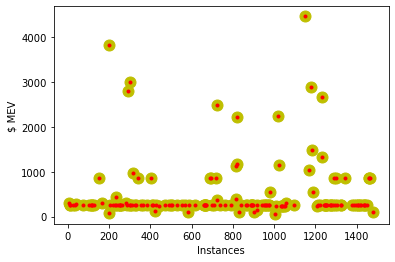

In [264]:
#Here are the predicted vs actual points of the test set. Reminder. our model has never seen these instances before.
#The yellow points are the actual ME values while the red points are the predicted ME values. As you can see, it is quite accurate!
fig, ax = plt.subplots(1,1)
plt.xlabel("Instances")
plt.ylabel('$ MEV')
ax.plot(y_test,'yo', markersize=11)
ax.plot(pd.Series(ridge_reg.predict(X_2_test), index=y_test.index),'ro', markersize=3)

It is clear that the regularized model is far superior to that of the simple linear regression.
A perfect model will have a slope of 1 with an intercept of 0, with no deviations. As you can see, this model should suffice.

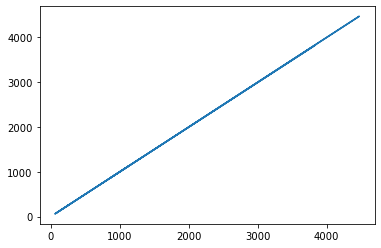

In [265]:
plt.plot(y_test, ridge_reg.predict(X_2_test))

Let us take a look at how the polynomial features are ordered, with their coefficients:
You will see feature names at position 0,5,10,...50. If two feature names are listed together, then the values were multiplied in order to make the polynomial feature data set.

## Lin. Regression Coefficients

In [266]:
[print(poly.get_feature_names(X.columns)[i]+' Coefficient of ',lin_reg.coef_[i]) for i in np.arange(0,50,5)]

1 Coefficient of  5.750961276660966e-05
x1_Purple Coefficient of  -8.713119025447172
x2_Product Placement Coefficient of  0.0017833155279731727
Location % Coefficient of  -8.149932765852668
Location Score Coefficient of  -0.20638727106449267
x0_NINJAVEGAS18 x0_NINJAVEGAS186m46s Coefficient of  1.861849099410451e-05
x0_NINJAVEGAS18 x2_Banner Sign Coefficient of  14.12662806131084
x0_NINJAVEGAS18 Duration Time Coefficient of  0.8491873200645728
x0_NINJAVEGAS18 Size Weight Coefficient of  86.77079271265168
x0_NINJAVEGAS18 ME Score Coefficient of  -147.1246678300957


[None, None, None, None, None, None, None, None, None, None]

## Ridge Regression Coefficients

In [267]:
[print(poly.get_feature_names(X.columns)[i]+' Coefficient of ',ridge_reg.coef_[i]) for i in np.arange(0,50,5)]

1 Coefficient of  0.0
x1_Purple Coefficient of  0.024031554019255576
x2_Product Placement Coefficient of  1.844963725679485e-05
Location % Coefficient of  0.06326650473789582
Location Score Coefficient of  0.00012991149198420015
x0_NINJAVEGAS18 x0_NINJAVEGAS186m46s Coefficient of  0.0
x0_NINJAVEGAS18 x2_Banner Sign Coefficient of  0.056180385386796615
x0_NINJAVEGAS18 Duration Time Coefficient of  -0.0092975986336041
x0_NINJAVEGAS18 Size Weight Coefficient of  -0.015046787496961728
x0_NINJAVEGAS18 ME Score Coefficient of  -0.008557213076488114


[None, None, None, None, None, None, None, None, None, None]

Lastly, let's take a look at which variables are the most important using a dictionary!

In [268]:
dict_coeff={}
for i in range(len(poly.get_feature_names(X.columns))):
    dict_coeff[poly.get_feature_names(X.columns)[i]]=ridge_reg.coef_[i]
series_sorter=pd.Series(dict_coeff)
series_sorter.sort_values(ascending=False)[:10]

Duration Time ME Score               3.871789
Duration Time Size Weight            1.556801
30 Second Equivalents ME Score       1.383724
Duration Time Brand Size %           0.778401
Duration Time Location %             0.667665
x1_Purple Duration Time              0.587463
x2_Banner Sign Duration Time         0.333706
Size Weight Clutter/SOV              0.320296
30 Second Equivalents Clutter/SOV    0.317826
Duration Weight Size Score           0.310436
dtype: float64

It seems rather strange that the regularized model takes a completely different approach.

## Saving the Model

Finally, let's save our model so that we can reproduce it later on!

In [269]:
joblib.dump(lin_reg, 'linear_reg_for_polynomial_of_2.pkl')
joblib.dump(ridge_reg, 'ridge_reg_for_polynomial_of_2.pkl')
joblib.dump(poly, 'polynomial_implementation.pkl')

['polynomial_implementation.pkl']

Let's also save our training and test sets just in case

In [270]:
X_2_df=pd.DataFrame(X_2, index=X.index, columns = poly.get_feature_names(X.columns))

In [271]:
X_2_df.to_csv('X_2.csv')
X.to_csv('cleaned_X.csv',index=False)
y.to_csv('y.csv', index=False)

# Additional Models and Analysis

In [273]:
Xy=X.copy()
Xy['MEV']=y

Remove SegID from num_columns and throw an error if there is one.

In [274]:
try:
    if 'MEV' not in num_columns:
        num_columns.append('MEV')
    num_columns.remove('SegID')
except Exception as x:
    print(x)

Let's look at a correlation heatmap!

<AxesSubplot:>

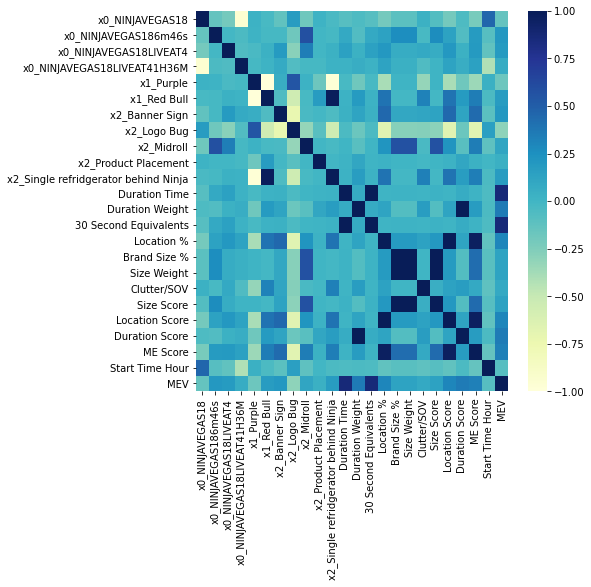

In [275]:
import seaborn
plt.figure(figsize=(7,7))
seaborn.heatmap(Xy.corr(), cmap='YlGnBu')

As you can see, the MEV has the highest correlation to the duration time and 30 Second equivalents

# Additional Models

Importing some additional packages: 

In [350]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

Let's create a custom analysis function for grid searches:

In [277]:
def show_scores_gs(X,y,model, show_cv_results=True):
    print('Best model parameters: ', model.best_params_)
    print('MSE on X set: ',mean_squared_error(model.predict(X),y))
    print('Mean Cross Val Score of Best Estimator: ', model.best_score_)
    if show_cv_results:
        print(model.cv_results_['mean_test_score'])

To determine whether scaling is of any use, I will create a transformer which just returns the data it was set. We will compare this with Standard Scalers.

In [278]:
class ReturnSelf(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return 1*X

In [279]:
svr=SVR()
ridge_reg_2=Ridge(tol=1e-4)
rfreg=RandomForestRegressor()

SVR didn't work very well. I just commented it out for the time being.

In [280]:
"""svr_grid = {'kernel':['rbf','linear','poly'], 'degree':[2,3], 'C':[5,10,15]}
svr_grid_search = GridSearchCV(svr, svr_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
svr_grid_search.fit(X, y)
show_scores_gs(X,y,svr_grid_search)"""

"svr_grid = {'kernel':['rbf','linear','poly'], 'degree':[2,3], 'C':[5,10,15]}\nsvr_grid_search = GridSearchCV(svr, svr_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)\nsvr_grid_search.fit(X, y)\nshow_scores_gs(X,y,svr_grid_search)"

The scores are highly variable relative to how many folds we use. We will search for the best alpha within the most promising region of 0<x<1. A cv of 5 achieves a much lower best MSE but also figures that a low alpha (.025) is optimal. This implies that it is not high enough as it does not take into account the extreme instances. A cv of 6 tends to do just fine however.

In [281]:
ridge_grid = {'alpha':list(np.arange(0,1,.1))}
ridge_grid_search = GridSearchCV(ridge_reg_2, ridge_grid, cv=6, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_2, y)
show_scores_gs(X_2,y,ridge_grid_search)

Best model parameters:  {'alpha': 0.1}
MSE on X set:  0.011102599585586586
Mean Cross Val Score of Best Estimator:  -5.218946111457166
[-6.64273695e+16 -5.21894611e+00 -6.01767893e+00 -6.19214460e+00
 -6.16526068e+00 -6.06845778e+00 -5.95126497e+00 -5.83406726e+00
 -5.72546361e+00 -5.62863261e+00]


We were able to only slightly improve the quality with grid search compared to the basic Ridge model from earlier in the code.

## Ridge and Lasso search (Elastic Net): optimal features

Elastic Net encompasses a mixture of L1 and L2 regularization, but for some reason the model began losing functionality after attaining a good model. The grid search determines that Ridge model performs better than Elastic Net with l2_ratio of 1.0

In [326]:
pipeline=Pipeline([ ('scaler',ReturnSelf()),('polynomial_scale',PolynomialFeatures()), ('Elastic_Net', ElasticNet(tol=.0001, max_iter=1000, random_state=2))])

parameters_pipeline=[{ 'scaler':[ReturnSelf(), StandardScaler()] ,'Elastic_Net__alpha':np.arange(0.1,.2,.3), 
                        'Elastic_Net__l1_ratio':np.arange(0,.2,.3)},
                     {'scaler':[ReturnSelf(), StandardScaler()], 'Elastic_Net':[Ridge(random_state=2)],'Elastic_Net__alpha':np.arange(0,1.1,.1)},
                     {'scaler':[ReturnSelf(), StandardScaler()], 'Elastic_Net':[Lasso(random_state=2)] ,'Elastic_Net__alpha':np.arange(0,1.1,.1)}]
grid_search_pipe = GridSearchCV(pipeline, parameters_pipeline,scoring='neg_mean_squared_error', cv=6, n_jobs=-1)
grid_search_pipe.fit(X,y)
show_scores_gs(X,y,grid_search_pipe, show_cv_results=False)

Best model parameters:  {'Elastic_Net': Ridge(alpha=0.1, random_state=2), 'Elastic_Net__alpha': 0.1, 'scaler': ReturnSelf()}
MSE on X set:  0.011102599585586586
Mean Cross Val Score of Best Estimator:  -5.218961229945236


## Ensemble model- AdaBoost optimal features

In [388]:
pipeline=Pipeline([ ('scaler',ReturnSelf()),('polynomial_scale',PolynomialFeatures()), ('Regressor', AdaBoostRegressor())])

parameters_pipeline_adaboost=[{ 'scaler':[ReturnSelf(), StandardScaler()] ,'polynomial_scale__degree':[1,2], 
                        'Regressor__base_estimator':[LinearRegression(),DecisionTreeRegressor()],
                         'Regressor__n_estimators':[150]}]
grid_search_adaboost = GridSearchCV(pipeline, parameters_pipeline_adaboost,scoring='neg_mean_squared_error', cv=6, n_jobs=-1)
grid_search_adaboost.fit(X,y)
show_scores_gs(X,y,grid_search_adaboost, show_cv_results=False)

Best model parameters:  {'Regressor__base_estimator': LinearRegression(), 'Regressor__n_estimators': 150, 'polynomial_scale__degree': 2, 'scaler': ReturnSelf()}
MSE on X set:  0.0005101298891464614
Mean Cross Val Score of Best Estimator:  -0.904367804578378


This model so far has the best cross val score. This value fluctuates highly between ~0.5 and ~7.0 so this value may not be the entire story.

In [ ]:
joblib.dump(grid_search_adaboost, 'pipeline_Ada_Boost.pkl')

## Random Forest Regressor
To show you the basis from which the $MEV was calculated, I will show you a non linear model

In [378]:
parameters_pipeline_RF=[{ 'scaler':[ReturnSelf(), StandardScaler()] ,'polynomial_scale__degree':[1,2], 'Regressor':[RandomForestRegressor()],
                        'Regressor__n_estimators':[150,300], 'Regressor__max_depth':[30], 'Regressor__min_samples_split':[2,20]}]
grid_search_RF = GridSearchCV(pipeline, parameters_pipeline_RF,scoring='neg_mean_squared_error', cv=6, n_jobs=-1)
grid_search_RF.fit(X,y)
show_scores_gs(X,y,grid_search_RF, show_cv_results=False)

Best model parameters:  {'Regressor': RandomForestRegressor(max_depth=30, n_estimators=150), 'Regressor__max_depth': 30, 'Regressor__min_samples_split': 2, 'Regressor__n_estimators': 150, 'polynomial_scale__degree': 2, 'scaler': ReturnSelf()}
MSE on X set:  9487.825254055893
Mean Cross Val Score of Best Estimator:  -52032.84284603471


This produces a very high error rate with cross validation!

## Custom Ensemble model 

I will create a custom class that allows us to have the ridge and adaboost models train on our X values, and then let a Linear regression model train on their outputs. The idea behind this is to maximize functionality by combining the novelties and structures of a regularized model and an ensemble model. This should not provide a significant improvement.

In [496]:
class CreateEnsembleModelsPredictions(BaseEstimator, TransformerMixin):
    def __init__(self, model1, model2):
        self.model1=model1
        self.model2=model2
    def fit(self, X, y):
        self.model1.fit(X,y)
        self.model2.fit(X,y)
        self.score(X,y)
        return self
    def score(self, X, y):
        cross_val_score_1, cross_val_score_2 = cross_val_score(self.model1,X,y, scoring='neg_mean_squared_error').mean(), cross_val_score(self.model2,X,y,scoring='neg_mean_squared_error').mean()
        print('cross validation score 1: ',cross_val_score_1)
        print('cross validation score 2: ',cross_val_score_2)
    def transform(self, X):
        new_X=self.model1.predict(X),self.model2.predict(X)
        return pd.DataFrame(new_X).T

pipeline_ensemble_ridge_adaboost = Pipeline([('polynomial',PolynomialFeatures(degree=2)), ('create_predictions',CreateEnsembleModelsPredictions(Ridge(alpha=0.1), 
                                            AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=150)))])
X_new=pipeline_ensemble_ridge_adaboost.fit_transform(X,y)

cross validation score 1:  -2.1188037568224374
cross validation score 2:  -3.87974370985865


Our custom pipeline returns data which we can use to train a new linear regression model:

In [459]:
X_new.head(3)

,0,1
0,754.021379,753.900000
1,264.802455,264.660133
2,862.110102,862.084186


This model technically cheats given that the models that it is based off have seen the entire training data, but this would be good if you are okay with using the entire data set for training.

In [498]:
cross_val_score(LinearRegression(),X_new,y, scoring='neg_mean_squared_error', cv=6).mean()

-0.0003584901313949834

## Predictions using the ensemble model:

In [500]:
lr=LinearRegression()
lr.fit(X_new,y)
lr.predict(X_new)[:7],y[:7]

(array([753.89432669, 264.64336317, 862.08234711, 267.31406524,
        262.51186969, 253.53987122, 222.11649098]),
 154     753.90
 1259    264.65
 688     862.09
 1313    267.32
 522     262.52
 1106    253.54
 68      222.10
 Name:  ME Value , dtype: float64)

As you can see, the model performs fairly well!

# Conclusion:

## Effect of Shuffling:

The following are the largest negative and positive differences among predicted values. The grid_search_pipe utilized a ridge regression model. Shuffling is far less important for other models that use bootstrapping such as the Decision Trees. This implies that the data that we had was not Independently and identically distributed (or I.I.D.)!

Before Shuffling:

In [132]:
diff=grid_search_pipe.predict(X)-y.values
print(np.sort(diff)[-11:-1],'\n',np.sort(diff)[0:10])

[21.9541731  22.14381983 22.16904134 27.71106104 27.73925956 29.31640097
 30.72446583 33.8931182  35.55649486 43.90162681] 
 [-79.67207811 -43.30895891 -35.02410601 -34.51280464 -29.06059131
 -24.20340243 -22.89421003 -22.87507844 -22.87507844 -22.75433228]


After Shuffling:

In [332]:
diff=grid_search_pipe.predict(X)-y.values
print(np.sort(diff)[-11:-1],'\n',np.sort(diff)[0:10])

[0.34845033 0.35234404 0.36355539 0.36856405 0.37080809 0.38904349
 0.39951156 0.40874145 0.46862184 0.49563571] 
 [-0.62821268 -0.53647866 -0.49199924 -0.47589831 -0.39430341 -0.34957283
 -0.3371224  -0.32305222 -0.3107713  -0.30735833]


## Statement:

On first sight, it appear to be a simple task.  Using a testing and training set results in a very low Mean squared error for both when training a regularized model. The problem, however, is that this low error is based and dependent solely on how you happen to split the data into training and test sets (aka. luck). 

When split into some folds, the testing set may not contain extreme instances which the model did not account for, which causes the test set MSE to spike. The solution is to 1) shuffle the data and/or 2) train your model by bootstrapping.

A cross validation technique is far more indicative of the model performance than using a train/test split, especially without shuffling, as it further accounts for the chance that a rare extreme value is not in one of the training sets but is in the relative testing set.

It is reasonable to assume that the basis of calculating the $MEV is derived from some sort of linear/polynomial model, so we decided on focusing on them.

Given the variation in the Cross Validation scores, it is wise for us to assume that a regularized model is superior to that of a plain linear model. Likewise, the models suggest strongly that a polynomial function applied on X is superior than not*. A variation in CV scores also motivates us to execute AdaBoost regression, which adds weights to the instances that it tends to produce higher errors for, and higher weights to the models that perform better. Despite being comprised of plain Linear Regression models, it performs even better than Ridge regression. These two methods achieve a far smaller error than pure Linear Regression.

The grid search and my custom transform function indicated that the models perform better when the data is not scaled. This is not too surprising as scaling is generally used for speeding up Gradient Descent or giving an equal weight distribution to variables.

The ultimate model would be one that is capable of using the strenghts of both a regularized model and an ensemble model composed of Lin. Regressors. This is where my custom CreateEnsembleModelsPredictions class comes into play. It first applies polynomial regression and trains both the previously mentioned models (with optimal parameters that we determined using Grid Search) and creates two datasets of the predicted $MEV (with a resulting MSE of around 2 for each). You can then create a linear regressor which takes the combined outputs into account to create an optimal output.